# Import Libraries

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE

import seaborn as sns

# Data Import and Preprocessing

### Define Transform

In [3]:
tensor = transforms.ToTensor()
normalize = transforms.Normalize((0.5,), (0.5,))
transformation = transforms.Compose([tensor, normalize])

### Import Data

In [5]:
training_dataset = datasets.MNIST('./dataset_q3',  train=True, transform=transformation)
testing_dataset = datasets.MNIST('./dataset_q3',  train=False, transform=transformation)

# Create Data Loader
train_data = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
test_data = torch.utils.data.DataLoader(testing_dataset, batch_size=64, shuffle=True)

In [24]:
# Correct to include all 10000 examples
train_features = []
train_labels = []
for features, labels in train_data:
    train_features.append(features.view(-1, 28*28).numpy())
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

test_features = []
test_labels = []
for features, labels in test_data:
    test_features.append(features.view(-1, 28*28).numpy())
    test_labels.append(labels.numpy())

test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

In [25]:
print("Length of train features: ", len(train_features))    
print("Length of train labels: ", len(train_labels))
print("Length of test features: ", len(test_features))
print("Length of test labels: ", len(test_labels))

Length of train features:  60000
Length of train labels:  60000
Length of test features:  10000
Length of test labels:  10000


### Sample Images in the Dataset

<Figure size 4000x4000 with 0 Axes>

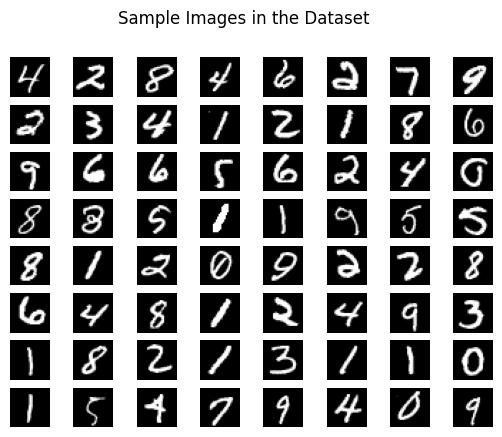

In [7]:
images, labels = next(iter(train_data))
plt.figure(figsize=(40, 40))
fig, ax = plt.subplots()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.axis('off')
fig.delaxes(ax)
plt.suptitle("Sample Images in the Dataset")
plt.show()

# Train the Model

### Define Model Architecture

In [8]:
class MLP(nn.Module):  # 3 Layer MLP with 128 neurons in the first layer, 64 in second and 10 in the output layer
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(28*28,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
        
    def forward(self,x):
        x = x.view(-1,28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_activations(self,x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        return torch.relu(self.fc2(x))

In [11]:
model = MLP()
untrained_model = copy.deepcopy(model)   # For getting t-sne of activations of untrained model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
epochs = 50
losses = []

### Outputs of the Untrained Model

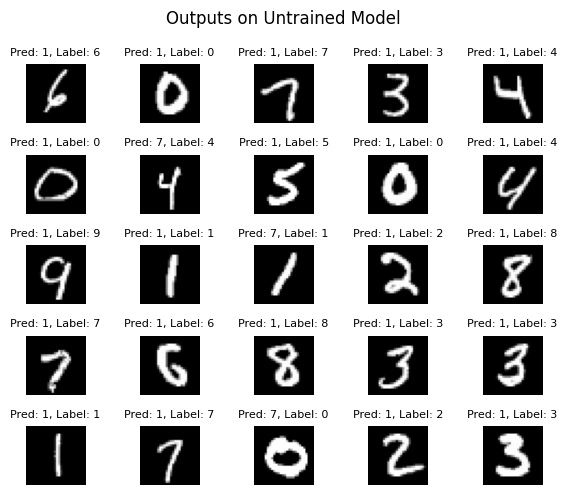

In [10]:
test_image, test_labels = next(iter(test_data))
fig, ax = plt.subplots(figsize=(6, 5))  

for i in range(25):
    pred = np.argmax(model(test_image[i].view(-1, 28*28)).detach().numpy())
    plt.subplot(5, 5, i+1)
    plt.imshow(test_image[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Pred: {pred}, Label: {test_labels[i].numpy()}', fontsize=8)  
    plt.axis('off')  

plt.suptitle("Outputs on Untrained Model")
fig.delaxes(ax)
plt.tight_layout()
plt.show()


### Training the model for 50 epochs

In [12]:
total = 0
losses = [] 
for e in range(epochs):
    for image, label in train_data:
        total += len(image)  
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  
    print(f"Epoch: {e+1} Loss: {loss.item()}")
print(f"Total Images = {total/epochs}")

Epoch: 1 Loss: 0.6482449769973755
Epoch: 2 Loss: 0.12459684163331985
Epoch: 3 Loss: 0.11984308063983917
Epoch: 4 Loss: 0.13916602730751038
Epoch: 5 Loss: 0.030468372628092766
Epoch: 6 Loss: 0.30458733439445496
Epoch: 7 Loss: 0.06698828935623169
Epoch: 8 Loss: 0.11008747667074203
Epoch: 9 Loss: 0.08607510477304459
Epoch: 10 Loss: 0.09905797988176346
Epoch: 11 Loss: 0.021819939836859703
Epoch: 12 Loss: 0.047018297016620636
Epoch: 13 Loss: 0.18000337481498718
Epoch: 14 Loss: 0.001839992357417941
Epoch: 15 Loss: 0.010981881991028786
Epoch: 16 Loss: 0.2364739030599594
Epoch: 17 Loss: 0.11618657410144806
Epoch: 18 Loss: 0.005262940190732479
Epoch: 19 Loss: 0.10205034911632538
Epoch: 20 Loss: 0.006137194577604532
Epoch: 21 Loss: 0.009303712286055088
Epoch: 22 Loss: 0.04435529187321663
Epoch: 23 Loss: 0.0007685062009841204
Epoch: 24 Loss: 0.00041673879604786634
Epoch: 25 Loss: 0.003014016430824995
Epoch: 26 Loss: 0.014698388986289501
Epoch: 27 Loss: 0.009042737074196339
Epoch: 28 Loss: 0.01804

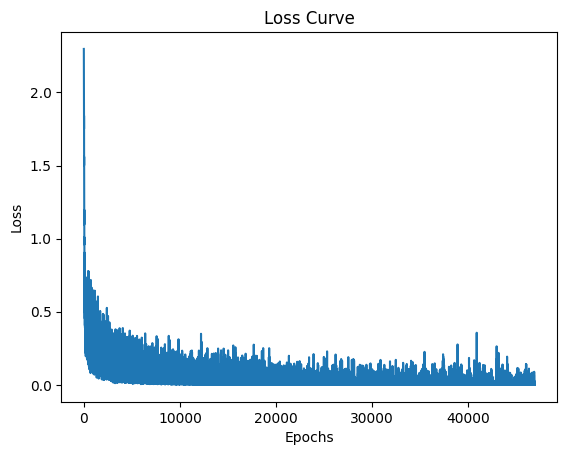

In [13]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

### Sample outputs of the Trained Model

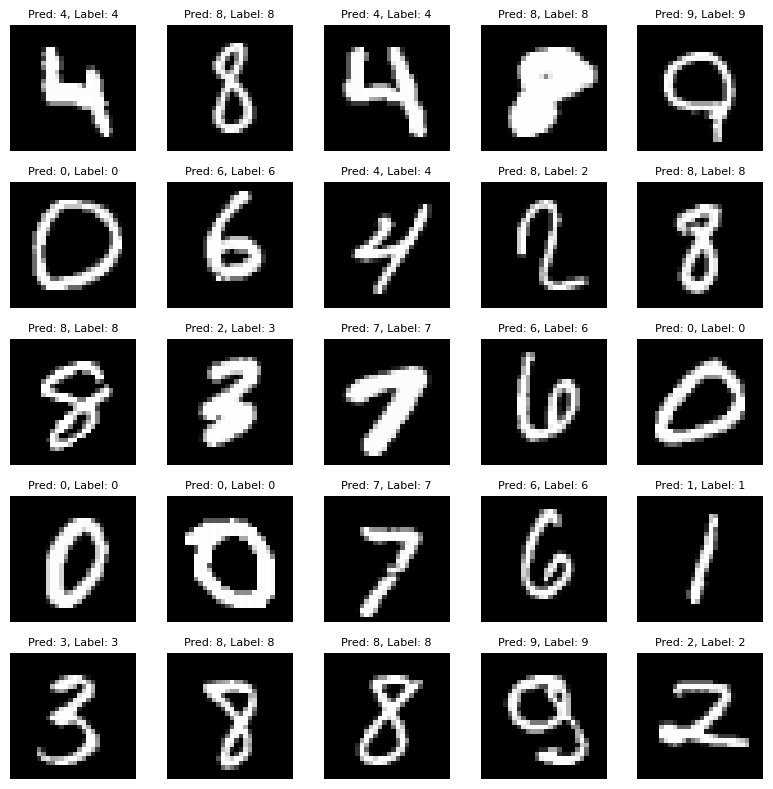

In [23]:
sample_test_image, sample_test_labels = next(iter(test_data))
fig, ax = plt.subplots(figsize=(8, 8))  
for i in range(25):
    pred = np.argmax(model(sample_test_image[i].view(-1, 28*28)).detach().numpy())
    plt.subplot(5, 5, i+1)
    plt.imshow(sample_test_image[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Pred: {pred}, Label: {sample_test_labels[i].numpy()}', fontsize=8)  
    plt.axis('off')  
fig.delaxes(ax)
plt.tight_layout()
plt.show()

In [58]:
total = 0 
y_pred = []
y_true = []
for image, label in test_data:
    total += len(image)  
    for i in range(len(image)):
        with torch.no_grad():
            output = model(image[i].view(-1, 28*28))
        y = np.argmax(output, axis=1)
        y_pred.append(y)
        y_true.append(label[i])
y_pred=np.array(y_pred).flatten()
y_true=np.array(y_true)
print(f"Shape of y_pred = {y_pred.shape}")
print(f"Shape of y_pred = {y_true.shape}")

Shape of y_pred = (10000,)
Shape of y_pred = (10000,)


### Metrics of the Trained MLP

In [55]:
accuracy = ((y_pred == y_true).sum()) / total * 100
print(f"Accuracy: {accuracy} %")
print(f"F1 Score: {f1_score(y_true, y_pred, average='macro')}")
cm_mlp = confusion_matrix(y_true, y_pred)
print("Confusion Matrix: ")
print(cm_mlp)

Accuracy: 97.78999999999999 %
F1 Score: 0.9777136539786685
Confusion Matrix: 
[[ 973    0    1    0    0    1    3    0    1    1]
 [   0 1125    1    2    0    3    1    0    2    1]
 [   6    0 1004    3    3    1    2    4    9    0]
 [   0    0    2  982    0    9    0    3   10    4]
 [   0    1    0    1  962    2    5    0    0   11]
 [   4    0    0    6    1  871    3    1    5    1]
 [   6    2    0    1    3    2  940    0    4    0]
 [   1    7    7    4    1    2    0  981    7   18]
 [   6    0    1    5    1    4    1    1  952    3]
 [   3    2    0    4    3    4    1    1    2  989]]


### Random Forest Classifier

In [27]:
rf = RandomForestClassifier() # Random Forest Classifier from sklearn
rf.fit(train_features, train_labels)
y_pred = rf.predict(test_features)
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score(test_labels, y_pred, average='macro')}")
cm_rf = confusion_matrix(test_labels, y_pred)
print(cm_rf)

Accuracy: 0.9686
F1 Score: 0.9683721962209522
[[ 969    0    1    0    0    3    3    1    3    0]
 [   0 1121    3    3    0    1    4    1    2    0]
 [   5    0 1001    4    3    0    4    9    6    0]
 [   0    0    9  972    0    7    0   11    9    2]
 [   1    0    2    0  955    0    5    0    2   17]
 [   4    0    1   16    3  856    4    2    3    3]
 [   7    3    0    0    2    2  938    0    6    0]
 [   1    2   21    2    0    0    0  991    3    8]
 [   5    0    5    8    4    6    5    5  926   10]
 [   6    5    3   12   14    1    1    4    6  957]]


### Logistic Regression

In [28]:
logistic = LogisticRegression(max_iter=1000)
logistic.fit(train_features, train_labels)
y_pred = logistic.predict(test_features)
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy*100} %")
print(f"F1 Score: {f1_score(test_labels, y_pred, average='macro')}")
cm_lr = confusion_matrix(test_labels, y_pred)
print(cm_lr)

Accuracy: 92.47999999999999 %
F1 Score: 0.9237909815674297
[[ 952    0    2    4    1   11    4    3    3    0]
 [   0 1110    6    2    0    2    3    1   11    0]
 [   7   11  926   15   11    3   12   10   34    3]
 [   4    1   19  921    2   23    3   10   19    8]
 [   1    3    7    3  922    0    7    5    6   28]
 [   9    4    3   36    9  778   13    6   30    4]
 [   9    3    7    2    4   17  914    1    1    0]
 [   1    7   22    9    5    1    0  947    4   32]
 [   8   13    7   22    9   23   10   11  857   14]
 [   8    7    2    9   24    7    0   21   10  921]]


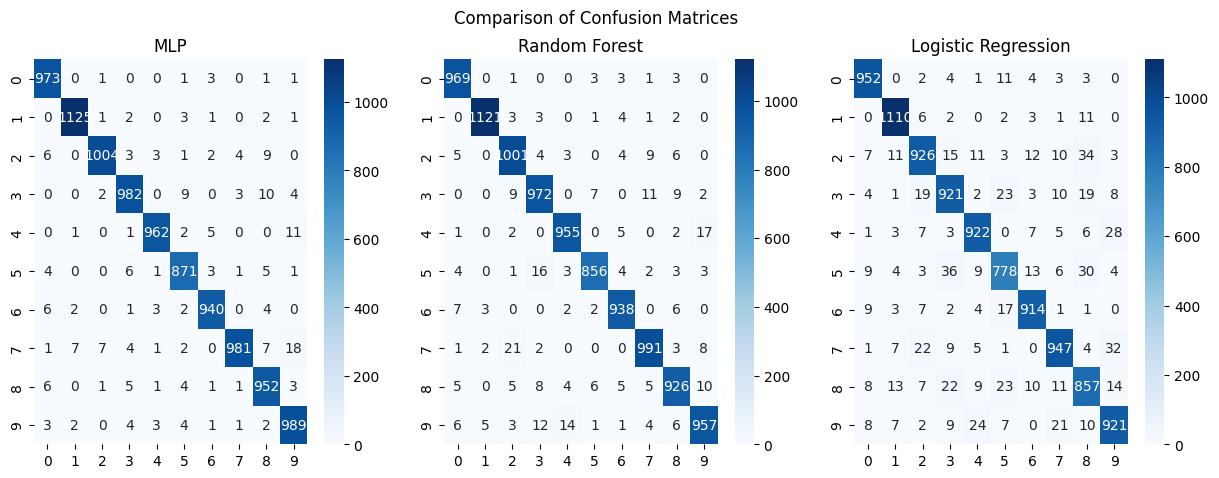

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(cm_mlp, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title("MLP")
sns.heatmap(cm_rf, annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title("Random Forest")
sns.heatmap(cm_lr, annot=True, fmt='d', ax=ax[2], cmap='Blues')
ax[2].set_title("Logistic Regression")
fig.suptitle('Comparison of Confusion Matrices')
plt.show()

| Model    | Accuracy | F1-Score|
| -------- | -------- | ------- |
| MLP  | 97.74 %     | 0.9771        |
| Random Forest | 97.12 %      | 0.9710        |
| Logistic   | 92.4 %     |   0.9229      |

### Observations:
- Multi-Layer Perceptron (MLP) has the highest percentage of accuracy, followed by Random Forest Classifier followed by Logistic Regression
- The same trend is also true for the F1-Score also.
- The digit 1 is most accuractely classified by all the models.

### Commonly Confused Digits:
From the confusion matrix of the three models, we can see that:
- 1 and 2 are confused. This may be possible because of writing two in a narrow way or 1 in different style than a straight line.
- 3 ans 8 are confused. This may be possible as both the numbers have similar semantics.
- 4 and 9 are confused. This may be possible as both the numbers have similar semantics.
- 7 ans 1 are confused. This may be possible because of the horizontal line of 7 being short.
- 7 ans 2 are confused. This may be possible because of similar semantics.
- 7 and 9 are confused. This may be possible because of similar semantics.

## Comparing the t-SNE of the Trained and Untrained Model

In [30]:
def extract_features(model, loader):
    activation = []
    label = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            activations = model.get_activations(images)
            activation.append(activations)
            label.append(labels)
    activation = torch.cat(activation).numpy()
    label = torch.cat(label).numpy()
    return activation, label

In [59]:
untrained_activations, _ = extract_features(untrained_model, test_data)
trained_activations, y_true = extract_features(model, test_data)
print(f"Shape of untrained activations = {untrained_activations.shape}")
print(f"Shape of trained activations = {trained_activations.shape}")

tsne_untrained = TSNE(n_components=2).fit_transform(untrained_activations)
tsne_trained = TSNE(n_components=2).fit_transform(trained_activations)

Shape of untrained activations = (10000, 64)
Shape of trained activations = (10000, 64)


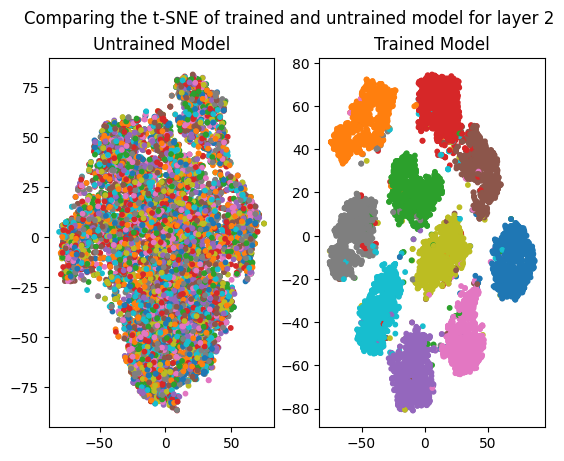

In [60]:
plt.subplot(1, 2, 1)
plt.scatter(tsne_untrained[:, 0], tsne_untrained[:, 1], c=y_true, cmap='tab10', s=10)
plt.title('Untrained Model')
plt.subplot(1, 2, 2)
plt.scatter(tsne_trained[:, 0], tsne_trained[:, 1], c=y_true, cmap='tab10', s=10)
plt.title('Trained Model')
plt.suptitle('Comparing the t-SNE of trained and untrained model for layer 2')
plt.show()

### Conclusion:
By observing the t-SNE plots for the trained and the untrained model, we can observe that the model has learnt the decision boundaries between the different number classes and has made them into different clusters. Therefore, we can conclude that the model is able to learn the digits well.

## Task 2:  Fashion-MNIST Dataset

### Loading Data

In [6]:
fashion_mnist_test = datasets.FashionMNIST('./Dataset_Q3', train=False, transform=transformation)
fashion_data = torch.utils.data.DataLoader(fashion_mnist_test, batch_size=64, shuffle=True)

### Sample Images from the Fashion-MNIST Dataset

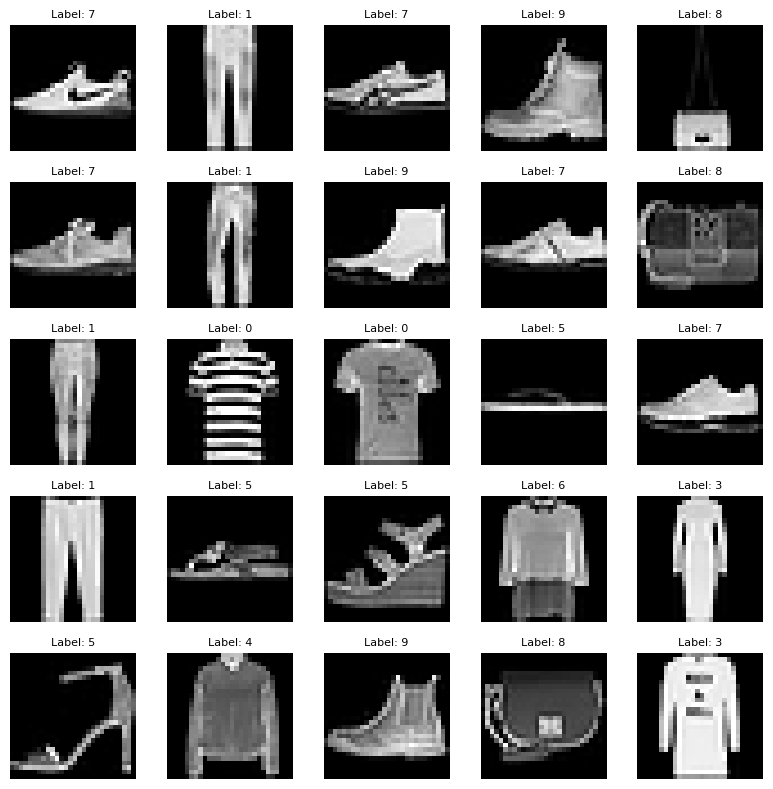

In [45]:
images, labels = next(iter(fashion_data))
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].numpy()}', fontsize=8)
    plt.axis('off')
fig.delaxes(ax)
plt.tight_layout()
plt.show()

### Predicting output of MNIST moddel on Fashion-MNIST

In [52]:
y_pred_fashion = []
y_true_fashion = []
for image, label in fashion_data:
    total += len(image)  
    for i in range(len(image)):
        with torch.no_grad():
            output = model(image[i].view(-1, 28*28))
        y = np.argmax(output, axis=1)
        y_pred_fashion.append(y)
        y_true_fashion.append(label[i])
y_pred_fashion=np.array(y_pred_fashion).flatten()
y_true_fashion=np.array(y_true_fashion)
print(f"Shape of y_pred_fashion = {y_pred_fashion.shape}")
print(f"Shape of y_true_fashion = {y_true_fashion.shape}")

Shape of y_pred_fashion = (10000,)
Shape of y_true_fashion = (10000,)


Accuracy: 1.1424999999999998 %
F1 Score: 0.044484294144763986


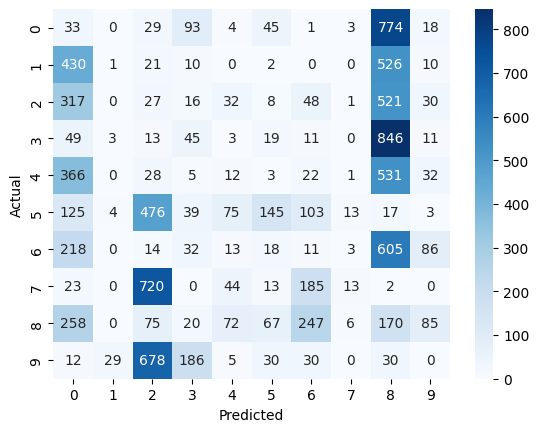

In [53]:
accuracy = ((y_pred_fashion == y_true_fashion).sum()) / total * 100
print(f"Accuracy: {accuracy} %")
print(f"F1 Score: {f1_score(y_true_fashion, y_pred_fashion, average='macro')}")
cm = confusion_matrix(y_true_fashion, y_pred_fashion)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Visualising the t-SNE for the Fashion Model and the Trained Model

(10000, 2) (10000, 2)


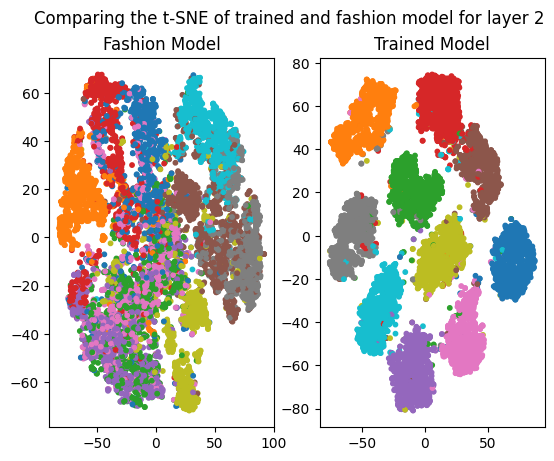

In [62]:
fashion_activations, y_fashion = extract_features(model, fashion_data)
tsne_fashion = TSNE(n_components=2).fit_transform(fashion_activations)
print(tsne_trained.shape, tsne_fashion.shape)
plt.subplot(1, 2, 1)
plt.scatter(tsne_fashion[:, 0], tsne_fashion[:, 1], c=y_fashion, cmap='tab10', s=10)
plt.title('Fashion Model')
plt.subplot(1, 2, 2)
plt.scatter(tsne_trained[:, 0], tsne_trained[:, 1], c=y_true, cmap='tab10', s=10)
plt.title('Trained Model')
plt.suptitle("Comparing the t-SNE of trained and fashion model for layer 2")
plt.show()

### Observations:
- The accuracy and F1-Score of the model is very low. This is because the Fashion-MNIST Dataset contains images of fashion items like shoes, t-shirts etc. while the model is trained on MNIST dataset, which contains digits. Therefore, as the model has learned only on the digits, it is not not surprising that it will not be able to classify the fashion items incorrectly.

- From the t-SNE graph of the Fashion-MNIST, we can see that is is highly confused than the trained model. Though, it is seperated some things into some diffused clusters, which is evident from the confusion matrix also, it is not able to get a clear decisino boundary for all the classes.